In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_dir = Path.home() / "Desktop" / "rbi-lite"
params_path = base_dir / "data" / "params.json"
inspection_csv = base_dir / "data" / "inspection_data.csv"
posterior_path = base_dir / "data" / "posterior_grid.csv"
fig_dir = base_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Load params
with open(params_path, "r", encoding="utf-8") as f:
    params = json.load(f)

t0 = float(params["t0_mm"])
t_min = float(params["t_min_mm"])
horizon_years = int(params["horizon_years"])
n_mc = int(params.get("n_mc", 20000))

# Load inspection data
insp = pd.read_csv(inspection_csv)
if "meas_std_mm" not in insp.columns:
    insp["meas_std_mm"] = float(params["meas_std_mm"])

# Load posterior grid
if not posterior_path.exists():
    raise FileNotFoundError("posterior_grid.csv belum ada. Simpan dulu dari Step 4.")

post_df = pd.read_csv(posterior_path)
r_grid = post_df["r_grid"].to_numpy(float)
posterior_pdf = post_df["posterior_pdf"].to_numpy(float)

# Normalize posterior pdf (safety)
posterior_pdf = posterior_pdf / np.trapezoid(posterior_pdf, r_grid)

print("Loaded OK:")
print("- params:", params_path)
print("- inspection:", inspection_csv)
print("- posterior:", posterior_path)

Loaded OK:
- params: C:\Users\LENOVO\Desktop\rbi-lite\data\params.json
- inspection: C:\Users\LENOVO\Desktop\rbi-lite\data\inspection_data.csv
- posterior: C:\Users\LENOVO\Desktop\rbi-lite\data\posterior_grid.csv


In [3]:
#Mengambil data terkini untuk measurement dan waktu sekarang
insp_sorted = insp.sort_values("time_years").reset_index(drop=True)
last_row = insp_sorted.iloc[-1]

t_now = float(last_row["time_years"])
th_meas_last = float(last_row["thickness_measured_mm"])
meas_std_last = float(last_row["meas_std_mm"])

print("Last inspection time (years):", t_now)
print("Measured thickness last (mm):", th_meas_last)
print("Measurement std last (mm):", meas_std_last)
print("Distance to t_min based on measured (mm):", th_meas_last - t_min)

Last inspection time (years): 4.0
Measured thickness last (mm): 9.827916234174374
Measurement std last (mm): 0.2
Distance to t_min based on measured (mm): 2.827916234174374


In [4]:
#Menentukan interval inspeksi 
interval_months = np.array([3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 77, 80])
interval_years = interval_months / 12
interval_years

array([0.25      , 0.5       , 0.75      , 1.        , 1.25      ,
       1.5       , 1.75      , 2.        , 2.25      , 2.5       ,
       2.75      , 3.        , 3.25      , 3.5       , 3.75      ,
       4.        , 4.25      , 4.5       , 4.75      , 5.        ,
       5.25      , 5.5       , 5.75      , 6.        , 6.25      ,
       6.41666667, 6.66666667])

In [5]:
#Menentukan biaya dan batas risiko
# biaya (contoh)
C_inspect = 5_000_000      # Rp 5 juta / inspeksi
C_fail = 500_000_000       # Rp 500 juta jika gagal (konsekuensi)

# batas risiko sederhana (contoh)
risk_limit = 0.01          # 1% peluang gagal sebelum inspeksi berikutnya

In [6]:
#Probability of Detection (POD)
# Definisi "kondisi berbahaya yang seharusnya terdeteksi"
t_detect = t_min + 0.5  # mm (zona dekat batas)
POD_high = 0.85         # peluang inspeksi mendeteksi jika sudah di zona berbahaya
POD_low = 0.05          # peluang false detection saat aman (opsional, bisa 0.0)

print("Detection threshold t_detect (mm):", t_detect)
print("POD_high:", POD_high, " | POD_low:", POD_low)

Detection threshold t_detect (mm): 7.5
POD_high: 0.85  | POD_low: 0.05


In [7]:
#Sampling laju korosi dari posterior
rng = np.random.default_rng(42)

# discrete probabilities for sampling r_grid
p_grid = posterior_pdf / posterior_pdf.sum()

idx = rng.choice(len(r_grid), size=n_mc, replace=True, p=p_grid)
r_post_samples = r_grid[idx]

print(pd.Series(r_post_samples).describe())

count    20000.000000
mean         0.528983
std          0.041041
min          0.356678
25%          0.501651
50%          0.529265
75%          0.556878
max          0.696098
dtype: float64


In [8]:
#Sampling ketebalan sekarang
th_now_samples = rng.normal(loc=th_meas_last, scale=meas_std_last, size=n_mc)

# Biar fisik, ketebalan tidak negatif dan tidak lebih dari t0 (optional, tapi rapi)
th_now_samples = np.clip(th_now_samples, 0.0, t0)

print(pd.Series(th_now_samples).describe())

count    20000.000000
mean         9.829926
std          0.201047
min          8.976514
25%          9.694487
50%          9.829379
75%          9.964438
max         10.693300
dtype: float64


In [9]:
def evaluate_interval_with_pod(
    delta_years: float,
    th_now: np.ndarray,
    r_samples: np.ndarray,
    t_min: float,
    t_detect: float,
    POD_high: float,
    POD_low: float,
    C_inspect: float,
    C_fail: float,
    rng: np.random.Generator
):
    """
    Return:
    - p_fail: P(gagal sebelum inspeksi berikutnya)
    - p_missed_fail: P(gagal sebelum inspeksi AND tidak terdeteksi)
    - expected_cost
    """
    r_safe = np.clip(r_samples, 1e-9, None)

    # Time to failure from now
    ttf = np.where(th_now <= t_min, 0.0, (th_now - t_min) / r_safe)

    fail_before_next = (ttf <= delta_years)

    # Time to enter detection zone
    ttd = np.where(th_now <= t_detect, 0.0, (th_now - t_detect) / r_safe)

    enters_detect_zone = (ttd <= delta_years)

    # Detection probability per scenario
    # If enters detect zone: POD_high else POD_low
    pod = np.where(enters_detect_zone, POD_high, POD_low)

    # Sample detection outcome
    detected = (rng.random(size=len(th_now)) < pod)

    # Missed failure = fail occurs AND not detected
    missed_fail = fail_before_next & (~detected)

    p_fail = fail_before_next.mean()
    p_missed_fail = missed_fail.mean()

    expected_cost = C_inspect + p_missed_fail * C_fail

    return p_fail, p_missed_fail, expected_cost

In [10]:
#Loop interval
rows = []
for m, d in zip(interval_months, interval_years):
    p_fail, p_missed_fail, exp_cost = evaluate_interval_with_pod(
        delta_years=float(d),
        th_now=th_now_samples,
        r_samples=r_post_samples,
        t_min=t_min,
        t_detect=t_detect,
        POD_high=POD_high,
        POD_low=POD_low,
        C_inspect=C_inspect,
        C_fail=C_fail,
        rng=rng
    )

    rows.append({
        "interval_months": int(m),
        "interval_years": float(d),
        "p_fail_before_next": p_fail,
        "p_missed_fail_before_next": p_missed_fail,
        "expected_cost": exp_cost
    })

result = pd.DataFrame(rows)
result["meets_risk_limit"] = result["p_fail_before_next"] <= risk_limit
result.sort_values("interval_months")

,interval_months,interval_years,p_fail_before_next,p_missed_fail_before_next,expected_cost,meets_risk_limit
0,3,0.250000,0.00000,0.00000,5000000.0,True
1,6,0.500000,0.00000,0.00000,5000000.0,True
2,9,0.750000,0.00000,0.00000,5000000.0,True
3,12,1.000000,0.00000,0.00000,5000000.0,True
4,15,1.250000,0.00000,0.00000,5000000.0,True
5,18,1.500000,0.00000,0.00000,5000000.0,True
6,21,1.750000,0.00000,0.00000,5000000.0,True
7,24,2.000000,0.00000,0.00000,5000000.0,True
8,27,2.250000,0.00000,0.00000,5000000.0,True
9,30,2.500000,0.00000,0.00000,5000000.0,True


In [11]:
result["cost_rate_per_year"] = (
    C_inspect / result["interval_years"]
    + result["p_missed_fail_before_next"] * C_fail / result["interval_years"]
)

In [12]:
#feasible = result[result["meets_risk_limit"]].copy()
#best = feasible.loc[feasible["cost_rate_per_year"].idxmin()]

In [13]:
#Pemilihan interval terbaik dengan batas risiko
feasible = result[result["meets_risk_limit"]].copy()

if len(feasible) == 0:
    print("Tidak ada interval yang memenuhi risk_limit.")
    print("Solusi: pilih interval lebih pendek, atau sesuaikan risk_limit/parameter.")
else:
    best = feasible.loc[feasible["cost_rate_per_year"].idxmin()]
    #best = feasible.loc[feasible["expected_cost"].idxmin()]
    print("REKOMENDASI INTERVAL INSPEKSI:")
    print(f"- Interval: {int(best['interval_months'])} bulan")
    print(f"- P_fail sebelum inspeksi: {best['p_fail_before_next']:.4f}")
    print(f"- P_missed_fail (POD effect): {best['p_missed_fail_before_next']:.4f}")
    print(f"- Expected cost: Rp {best['expected_cost']:,.0f}")

REKOMENDASI INTERVAL INSPEKSI:
- Interval: 45 bulan
- P_fail sebelum inspeksi: 0.0005
- P_missed_fail (POD effect): 0.0002
- Expected cost: Rp 5,100,000


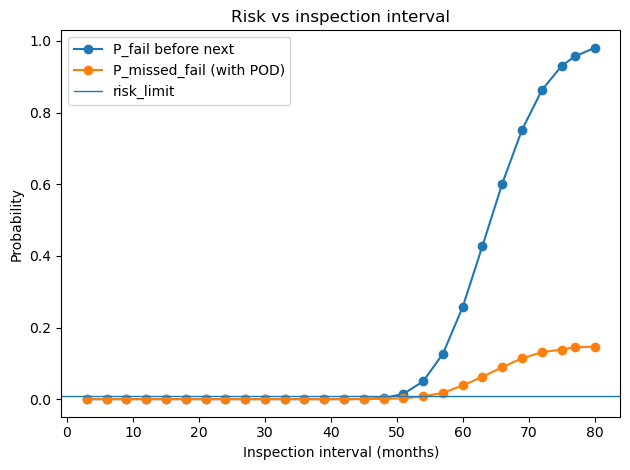

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step5_risk_vs_interval_with_pod.png


In [14]:
#Plot risk vs interval
plt.figure()
plt.plot(result["interval_months"], result["p_fail_before_next"], marker="o", label="P_fail before next")
plt.plot(result["interval_months"], result["p_missed_fail_before_next"], marker="o", label="P_missed_fail (with POD)")
plt.axhline(risk_limit, linewidth=1, label="risk_limit")
plt.xlabel("Inspection interval (months)")
plt.ylabel("Probability")
plt.title("Risk vs inspection interval")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "step5_risk_vs_interval_with_pod.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step5_risk_vs_interval_with_pod.png")

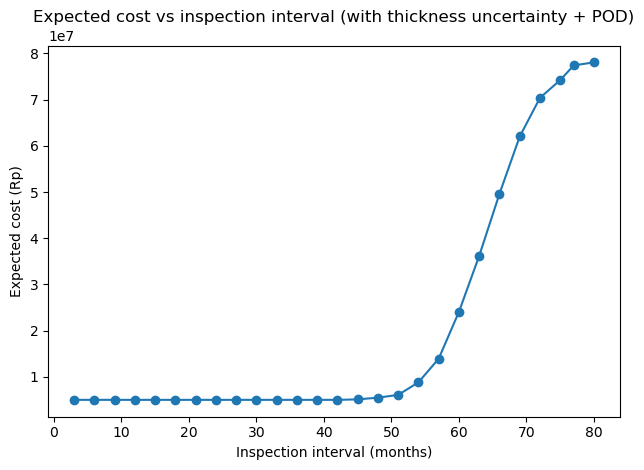

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step5_cost_vs_interval_with_pod.png


In [15]:
#Plot expected cost vs interval
plt.figure()
plt.plot(result["interval_months"], result["expected_cost"], marker="o")
plt.xlabel("Inspection interval (months)")
plt.ylabel("Expected cost (Rp)")
plt.title("Expected cost vs inspection interval (with thickness uncertainty + POD)")
plt.tight_layout()
plt.savefig(fig_dir / "step5_cost_vs_interval_with_pod.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step5_cost_vs_interval_with_pod.png")

In [16]:
#Simpan tabel ke .csv
out_path = base_dir / "data" / "step5_interval_results.csv"
result.to_csv(out_path, index=False)
print("Saved table:", out_path)

Saved table: C:\Users\LENOVO\Desktop\rbi-lite\data\step5_interval_results.csv
